# Asset Pricing 2: Homework 3

### Trent Potter

### Winter 2025

---


### Pseudo Function Headers
This gives an overview of the code base while also hitting on the flow of the notebook.  Reading top-to bottom gives the 

* `construct_B(d1, phi)` - generate our $B_n$ recurence matrix using parameter estimates of $d_1$ and $\Phi^*$
* `construct_sigma(B_pc, simga_pc)` - using our derived $B_{PC}=QB_y$ recurrence, we estimate the covariance of the term structure at the granularity of every maturity, $\Sigma$
* `construct_a(d0, B, sigma, mu=None)` - Construct our $a_y$ recurrence as a function of the $B_y$ recurrence, the estimate maturity covariance $\Sigma$, the $d_0$ search parameter, and an optional $\mu$ (or $\mu^*$ depending on the interpretation)
* `construct_x(B_pc, f, Q, a)` - Back out our unobservable $x_t$ from the observable yields $y_t$ inverting the affine pricing model (projected onto the factor orthonormal basis $Q$)
* `construct_y(a, B, x)` - Generate estimates of yields $\hat{y_t}$ using our $B_y$ and $x_t$ estimates.
* `square_loss(y, y_hat)` - Simple scoring function for MSE.
* `parameter_search(initial_d0, initial_phi)` -  Numerical search for $\Phi$ and $d_0$ to solve $\arg\min \sum_{n=1}^N \sum_{t=1}^{T} \left( y_t^n - \widehat{y_t^n} \right)^2$
* `var_pc(f)` - Solve for $\Phi_{PC}$ and $\mu_{PC}$ from a single lag VAR model on factor scores
* `construct_implied_phi_pc(phi, B_pc)` - Projection of optimization result $\Phi^*$ (hidden state VAR parameter) onto factor risk basis $B_{PC}$ (See above) 
* `construct_mu(excess_returns, variance, B)` - Examine empirical excess expected returns scaled by $b_{n-1}$ for a given maturity, $n$.  With $\Lambda_1 = 0$ we have $\mathbb{E}_t[r_{n, t+1} - y_{1,t}] + \frac{1}{2} var_t(r_{n, t+1}) = b_{n-1} \Sigma \lambda_0 = b_{n-1} (\mu - \mu^*) = b_{n-1}\mu$
* `construct_lambda(mu, sigma)` - Using the assertion $\mu^* = \mu - \Sigma \lambda_0 = 0$ we solve for $\Sigma^{-1}\mu = \lambda_0$ or (depending on inputs) $\Sigma_{PC}^{-1} \mu_{PC} = \lambda_{0,PC}$
* `construct_factor_sharpe(lambda_pc, sigma_pc)` $\text{PC Sharpe Ratio} = \Sigma_{PC}^{1/2}\lambda_{0,PC}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.optimize import minimize
from statsmodels.tsa.vector_ar.var_model import VAR
np.set_printoptions(linewidth=144, precision=4,suppress=True)

K = 3 # number of principal components
yield_file_name = "yields.csv"
y = pd.read_csv(yield_file_name)
N = y.columns.size - 1

# Convert percentage yields to log yields
for col in y.columns[1:]:  # Skip 'date' column
    y[col] = (1 + y[col] / 100).apply(np.log)

# Compute first differences (log yield changes)
dy = y.copy()
dy.iloc[:, 1:] = y.iloc[:, 1:].diff()
dy.dropna(inplace=True)

# Compute covariance matrix of log yield changes
dy_cov = dy.iloc[:, 1:].cov()

In [2]:
############################################
# Helper functions to increase readability #
############################################

def construct_B(d1, phi):
  """No assumptions for JSZ normalization here, but could simplify this if we did."""
  assert isinstance(phi, np.ndarray), "phi must be a numpy array"
  if phi.ndim == 1:
    phi = np.diag(phi)
  assert phi.ndim == 2 and phi.shape[0] == phi.shape[1], "phi must be a square matrix"
  assert len(d1) == phi.shape[0], "length of d1 must match the side length of phi"
  
  # iterative calculation of each row of B
  B = np.zeros((N,K))
  B[0, :] = -d1
  for i in range(1, N):
    B[i, :] = -d1 + B[i-1, :] @ phi
  for i in range(N):
    B[i, :] /= (i+1)
  return B

def construct_sigma(B_pc, simga_pc):
  return np.linalg.inv(B_pc) @ simga_pc @ np.linalg.inv(B_pc.T)

def construct_a(d0, B, sigma, mu=None):
  if mu is None:
    mu = np.zeros(B.shape[1])
  a = np.full(len(B), -d0)
  for i in range(1, len(a)):
    # we've already added '-d0' terms, just do the a(n-1) and b(n-1) terms
    a[i] += a[i-1] + B[i-1] @ mu + 1/2 * B[i-1] @ sigma @ B[i-1].T
  for i in range(len(a)):
    a[i] /= i+1
  return a

def construct_x(B_pc, f, Q, a):
  """Back out our unobservable x_t from the observable yields y_t inverting the affine pricing model (projected onto the factor orthonormal basis Q)."""
  x = -np.linalg.inv(B_pc) @ (f.T + Q.T @ a[:, np.newaxis])
  return x.T

def construct_y(a, B, x):
  """Generate estimates of yields y_hat using our B_y and x_t estimates."""
  y_hat = -a - (B @ x.T).T
  return y_hat

def square_loss(y, y_hat):
  """Simple scoring function for MSE."""
  return ((y - y_hat) ** 2).sum().sum()

def generate_loss_for_params(params, Q, sigma_pc, f, y):
    N, K = Q.shape
    d0, phi = params[0], params[1:]
    phi = np.diag(phi)
    d1 = np.ones(K)
    B = construct_B(d1, phi)
    B_pc = Q.T @ B
    sigma = construct_sigma(B_pc, sigma_pc)
    a = construct_a(d0, B, sigma)
    x = construct_x(B_pc, f, Q, a)
    y_hat = construct_y(a, B, x)
    return square_loss(y, y_hat)

def parameter_search(initial_d0, initial_phi, Q, f, sigma_pc, y):
  """Numerical search for Phi and d_0 to solve argmin sum_{n=1}^N sum_{t=1}^{T} (y_t^n - y_hat_t^n)^2."""
  if initial_phi.ndim == 1:
    initial_phi = np.diag(initial_phi)
  if not isinstance(y, np.ndarray):
    y = y.values
    
  T, N = y.shape
  _, K = Q.shape
  assert initial_phi.shape == (K,K), "initial_phi must match the number of principal components"
  assert f.shape == (T,K), "f shape must match (T,K) the number yield time periods and principal components"
  assert sigma_pc.shape == (K,K), "sigma_pc shape must match (K,K) the number of principal components"
  assert Q.shape == (N,K), "y shape must match (T,N) the number of yield time periods and maturities"

  # Phi is diagonal, only pass that in so we search along the diagonal
  initial_params = np.hstack([initial_d0, np.diag(initial_phi)])
  curry_function_loss = lambda params: generate_loss_for_params(params, Q, sigma_pc, f, y)
  result = minimize(curry_function_loss, initial_params, method='L-BFGS-B')
  return result

def var_pc(f):
  """Solve for Phi_PC and mu_PC from a single lag VAR model on factor scores."""

  model = VAR(f)
  results = model.fit(1)
  Phi_PC = results.coefs[0]
  mu_PC = results.intercept
  return Phi_PC, mu_PC

def construct_implied_phi_pc(phi, B_pc):
  """Projection of optimization result Phi* onto factor basis Q."""
  return  B_pc @ phi @ np.linalg.inv(B_pc)

## #1 Principal Components of Log Yield Differences
We find the standard level, slope, convexity result below.

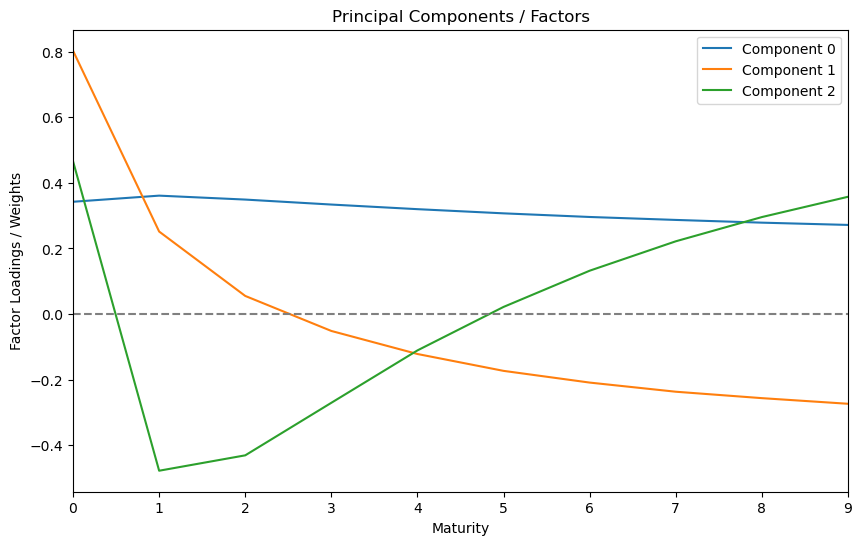

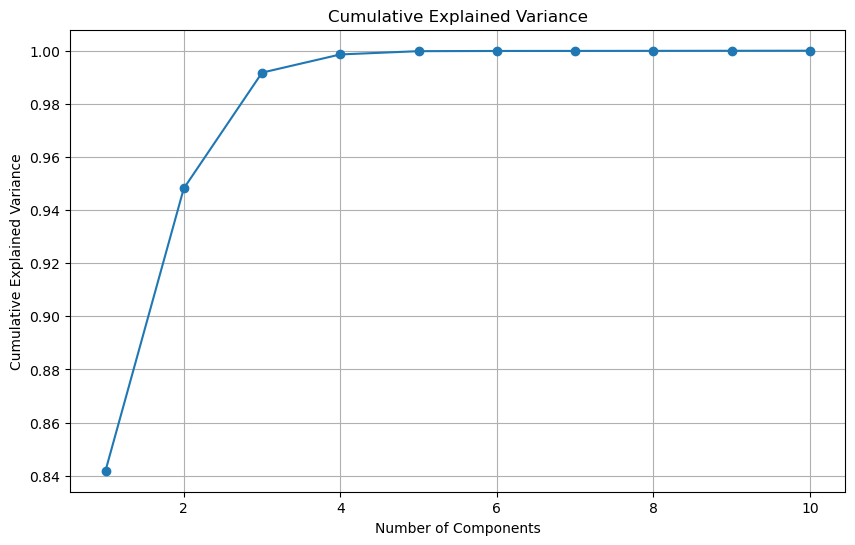

In [3]:
eig_vals, eig_vecs = np.linalg.eig(dy_cov)
# Plotting functions
def plot_explained_variance(eig_vals):
    explained_variance = np.cumsum(eig_vals) / np.sum(eig_vals)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

def plot_components(components):
    num_components = len(components)
    plt.figure(figsize=(10, 6))
    for i, comp in enumerate(components):
        plt.plot(comp, label=f'Component {i}')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Principal Components / Factors')
    plt.xlabel('Maturity')
    plt.ylabel('Factor Loadings / Weights')
    plt.xlim([0, components.shape[1]-1])
    plt.legend()
    plt.show()
    
    
Q = eig_vecs[:, :K]
plot_components(Q.T)
plot_explained_variance(eig_vals)


## #2 Factors, $\Sigma_{PC}$, and $\Sigma$
We note the covariance below of the the factor structure, and constrain it to just the diagonal; this is for numerical stability, it's gauranteed based off the construction since the factors are orthogonal.  Looking to construct $\Sigma$ from our factor information, we first need a transform for the risk exposure of a maturity to the hidden process ($B_y$) and then we need to transform that into the risk exposure of a factor to the factor process ($B_{PC}$ using $Q$).  With these in hand we can map our estimated factor risks $\Sigma_{PC}$ into $\Sigma$.

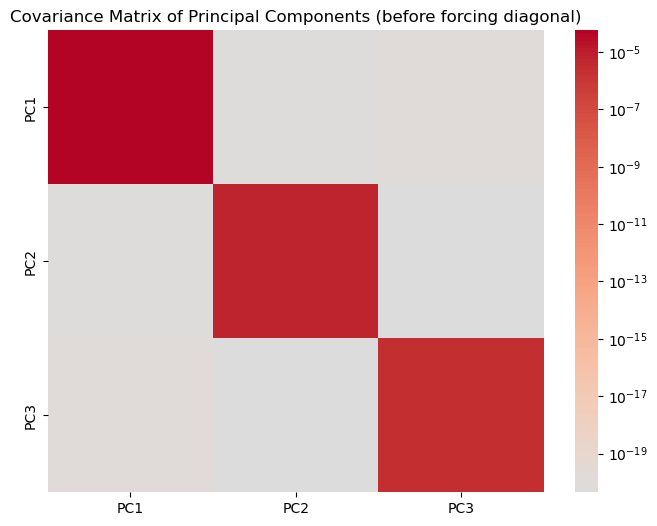

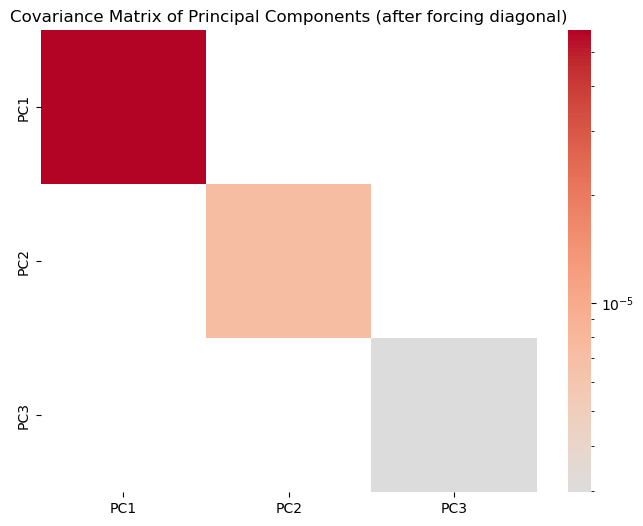

In [4]:
# Create factors from principal components, Q, and log yields
f =  y.iloc[:,1:] @ Q
df = f.diff().dropna()

sigma_pc = np.cov(df.T)
plt.figure(figsize=(8, 6))
sns.heatmap(sigma_pc, center=0, cmap='coolwarm', xticklabels=['PC1', 'PC2', 'PC3'], yticklabels=['PC1', 'PC2', 'PC3'], norm=LogNorm())
plt.title('Covariance Matrix of Principal Components (before forcing diagonal)')
plt.show()

# Given that each column of df is linearly independent by construction, we can assert a diagonal covariance
sigma_pc = np.diag(np.diag(sigma_pc)) 
plt.figure(figsize=(8, 6))
sns.heatmap(sigma_pc, center=0, cmap='coolwarm', xticklabels=['PC1', 'PC2', 'PC3'], yticklabels=['PC1', 'PC2', 'PC3'], norm=LogNorm())
plt.title('Covariance Matrix of Principal Components (after forcing diagonal)')
plt.show()

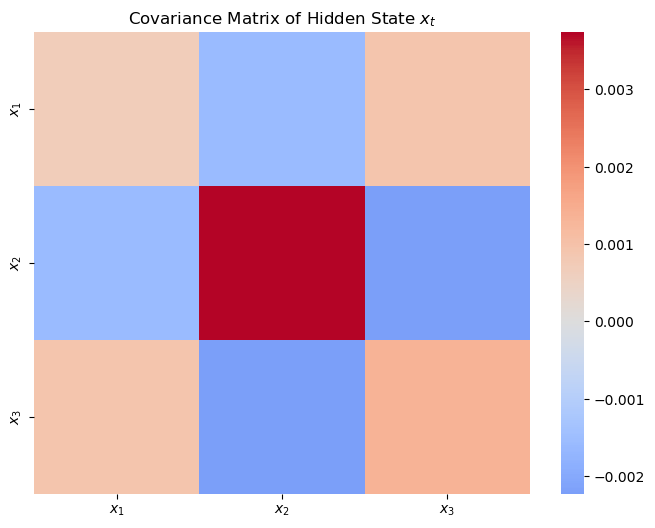

In [5]:
test_d0 = .05
d1 = np.ones(K)
phi_pc, mu_pc = var_pc(f)
initial_phi = np.diag(np.diag(phi_pc)) # restrict to diagonal

B = construct_B(d1, initial_phi)
B_pc = Q.T @ B
test_sigma = construct_sigma(B_pc, sigma_pc)

plt.figure(figsize=(8, 6))
labels = [f'$x_{i}$' for i in range(1,4)]
sns.heatmap(test_sigma, center=0, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Covariance Matrix of Hidden State $x_t$')
plt.show()



## #3 Point Estimates and Analysis of $\Phi^*_{PC}$ versus $\Phi_{PC}$

First some results, then analysis:

### Optimization Point Estimates

$ d_0 = 0.0683$

$\Phi^* =
\begin{bmatrix}
0.9372    & 0 & 0 \\
0 & 0.6785 & 0 \\
0 & 0 & 0.292
\end{bmatrix}$


### Risk-Neutral VAR Coefficients ($\Phi^*_{PC}$)

| Factor  | Level (t-1) | Slope (t-1) | Convexity (t-1) |
|---------|------------|-------------|-----------------|
| **Level**    | 0.9612     | 1.0989      | 0.6320          |
| **Slope**    | -0.0409    | 0.2276      | -1.4847         |
| **Convexity** | -0.0052    | -0.0094     | 0.7189          |


### Physical VAR Coefficients ($\Phi_{PC}$)

| Factor  | Level (t-1) | Slope (t-1) | Convexity (t-1) |
|---------|------------|-------------|-----------------|
| **Level**    | 1.0014     | 0.0239      | 0.1257          |
| **Slope**    | -0.0044    | 0.8991      | -0.2331         |
| **Convexity** | -0.0059    | -0.0618     | 0.7599          |


### Difference ($\Phi^*_{PC} - \Phi_{PC}$)

| Factor  | Level (t-1) | Slope (t-1) | Convexity (t-1) |
|---------|------------|-------------|-----------------|
| **Level**    | -0.0402    | 1.0749*      | 0.5064**          |
| **Slope**    | -0.0365    | -0.6715     | -1.2515***         |
| **Convexity** |  0.0007    | 0.0523      | -0.0409         |

---

### Interpretation
Both instances of Phi show strong levels of autocorrelation (the diagonals).  Notably on this diagonal, the risk-neutral AC for slope is much less persistent relative to the simple VAR model.

The more interesting are the implications for the $\phi{level, slope}$, $\phi{level, convexity}$, and $\phi{slope, convexity}$ elements.  Each can be interpreted as the risk-neutral (and more importantly SDF bound) model better incorporating information about the expectations hypothesis.  

In the first case, levels lag coefficient on slope, we see that $\phi^*$ places strong positive weight on positive slope weight.  Said another way, when the slope was high yesterday, that implies that level will increase tomorrow.  This can be viewed as an expectations hypothesis result; intuitively as time passes from $t$ to $t+1$, maturity $n$ is now $n-1$, bringing with it a relatively higher yield given that lower yields on the left end of the curve have less duration.

The second case follows a similar arguement.  In the short-run (a single, 1-month lag), high-convexity implies that the next period will see low-yield maturities "fall off" the left end of the yield curve and higher-yield maturities will converge upward toward their higher forward rates given fewer 'low forward rate' maturities.

The last case takes the arguement to the derivative of the curve.  We're now weighting very negatively on convexity when predicting tomorrow's slope.  This, again, intuitively makes sense as the convexity 'shape' implied by a high PC moves left on the curve, we'd expect the right-side of the term structure to come off while the left is rising.

Focusing on these relatively larger dimensions of difference, we can interpret that the misspecifications of the model are likely to arise in the panel data rather than cross-sectionally.  Getting the dynamics specified in a way that captures the expectations hypothesis will be important for understanding the underlying process and hence the errors, conditional SDFs, and risk premia.


### [Side Note] Approach to Find $\Phi_{PC}^*$

To obtain $\Phi_{PC}^*$, we use the fact that the PC factors and the hidden states are related via:

$$
x_t = -B_{PC}^{-1} (f_t + Q' a_y)
$$

Substituting this into the risk-neutral hidden state VAR:

$$
x_{t+1} = \Phi^* x_t + \Omega \varepsilon_{t+1}
$$

Substituting from above:

$$
-B_{PC}^{-1} (f_{t+1} + Q' a_y) = \Phi^* (-B_{PC}^{-1} (f_t + Q' a_y)) + \Omega \varepsilon_{t+1}
$$

Multiplying both sides by $ B_{PC} $, we get:

$$
f_{t+1} + Q' a_y = B_{PC} \Phi^* B_{PC}^{-1} (f_t + Q' a_y) + B_{PC} \Omega \varepsilon_{t+1}
$$

Letting:

$$
\Phi_{PC}^* = B_{PC} \Phi^* B_{PC}^{-1}
$$

We now have:

$$
f_{t+1} = \Phi_{PC}^*f_t  + (\Phi_{PC}^* -1) Q' a_y + B_{PC} \Omega \varepsilon_{t+1}
$$

We can further reduce to "PC" specifications of the risk neutral VAR:

$$ \Omega_{PC} = B_{PC} \Omega $$

$$ \mu^*_{PC} = (\Phi_{PC}^* -1) Q' a_y $$

Yield a simplified PC risk-neutral VAR:

$$
f_{t+1} = \Phi_{PC}^*f_t  + \mu^*_{PC} + \Omega_{PC} \varepsilon_{t+1}
$$

Since $ B_{PC} = Q' B_y $, this transformation allows us to project the hidden state risk-neutral dynamics into the principal component space.

In [6]:
#Construct the rest of the initial estimates so we have a base-case loss & intermediate values
test_a = construct_a(test_d0, B, test_sigma)
test_x = construct_x(B_pc, f, Q, test_a)
test_y_hat = construct_y(test_a, B, test_x)
test_loss = square_loss(test_y_hat, y.iloc[:,1:].values)

print(f"Initial Guess Loss: {test_loss: 0.4f}")

# Run the optimization
result = parameter_search(test_d0, initial_phi, Q, f, sigma_pc, y.iloc[:,1:].values)
d0_opt, phi_star_opt = result.x[0], result.x[1:]


print("Optimization Result:")
print(f"Message: {result.message}")
print(f"Success: {result.success}")
print(f"Final Loss (fun): {result.fun: 0.4f}")
print(f"Optimal d0: {d0_opt: 0.4f}")
print(f"Optimal phi* diagonal: {phi_star_opt}")

Initial Guess Loss:  0.0017
Optimization Result:
Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Success: True
Final Loss (fun):  0.0005
Optimal d0:  0.0683
Optimal phi* diagonal: [0.9372 0.6785 0.292 ]


In [7]:
# Use optimal parameters to generate optimal intermediate values
B_opt = construct_B(d1, phi_star_opt)
B_pc_opt = Q.T @ B_opt 

sigma_opt = construct_sigma(B_pc_opt, sigma_pc)
a_opt = construct_a(d0_opt, B_opt, sigma_opt)
x_opt = construct_x(B_pc_opt, f, Q, a_opt)
opt_y_hat = construct_y(a_opt, B_opt, x_opt)
opt_loss = square_loss(opt_y_hat, y.iloc[:,1:].values)

# project phi_star back onto the factor risk basis B_y Q
phi_star_pc = construct_implied_phi_pc(np.diag(phi_star_opt), B_pc_opt)

print("phi*_pc:\n", phi_star_pc)
print("phi_pc:\n", phi_pc)
print("difference:\n", phi_star_pc - phi_pc)


phi*_pc:
 [[ 0.9612 -1.0989 -0.632 ]
 [ 0.0409  0.2276 -1.4847]
 [ 0.0052 -0.0094  0.7189]]
phi_pc:
 [[ 1.0014 -0.0239 -0.1257]
 [ 0.0044  0.8991 -0.2331]
 [ 0.0059 -0.0618  0.7599]]
difference:
 [[-0.0402 -1.0749 -0.5064]
 [ 0.0365 -0.6715 -1.2515]
 [-0.0007  0.0523 -0.0409]]


## #4 Model Fit
The model fits the in-sample data extraordinarily well. The largest difference observed is in the 10-year case in month 100, with a 6 basis point difference. This indicates a high level of accuracy in the model's predictions.  Diving into the worst case fits, we see actual yield curves that seem to exibit strong concavity then convexity (or vice-versa) within the 3 periods.  This seems like a potentail case to add the fourth factor to the model.

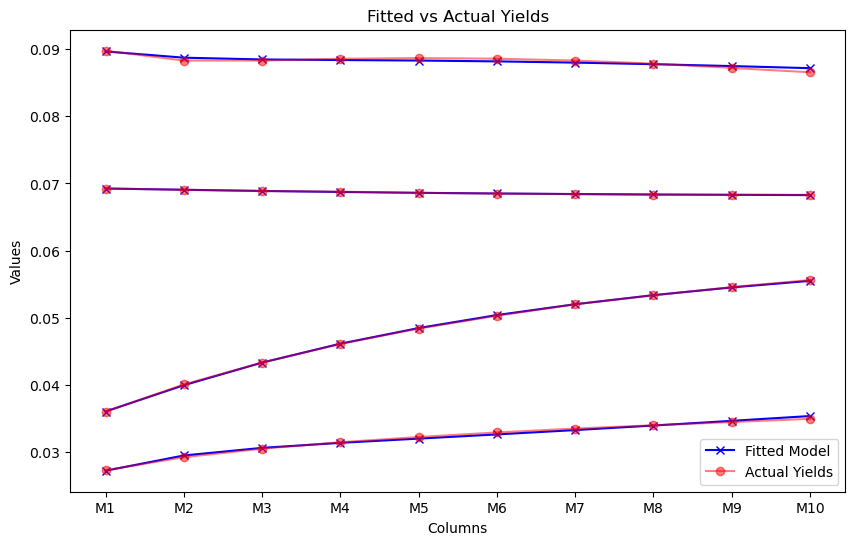

In [8]:
def plot_selected_rows(df1, df2, rows, title=''):
  plt.figure(figsize=(10, 6))
  for row in rows:
    plt.plot(df1.columns, df1.iloc[row], 'bx-', alpha=1, label=f'Fitted Model' if row == rows[0] else "")
    plt.plot(df2.columns, df2.iloc[row], 'ro-', alpha=.5, label=f'Actual Yields' if row == rows[0] else "")
  plt.title(title)
  plt.xlabel('Columns')
  plt.ylabel('Values')
  plt.legend()
  plt.show()

plot_selected_rows(opt_y_hat, y.iloc[:, 1:], [100, 200, 300, 400], title='Fitted vs Actual Yields')

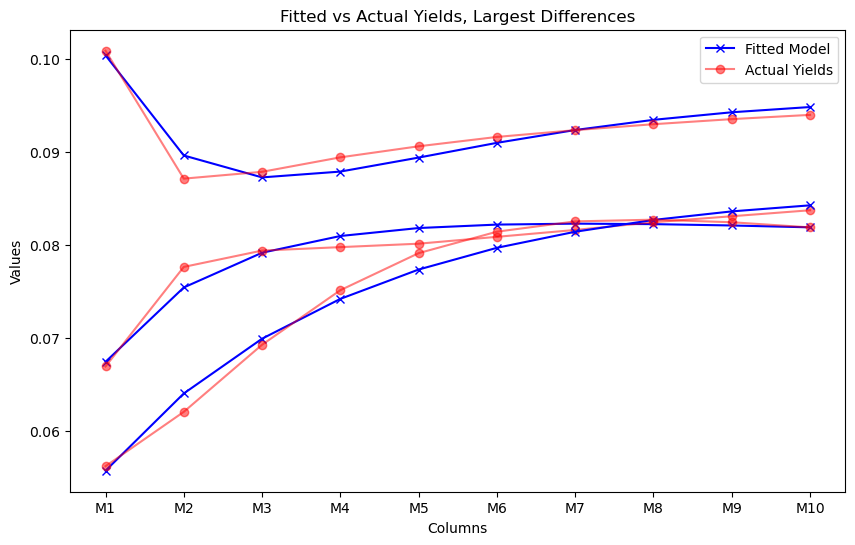

In [9]:
# Calculate the difference and multiply by 100
diff = (opt_y_hat - y.iloc[:, 1:].values) * 100

# Sort the rows by their maximum values
sorted_diff = diff.iloc[np.argsort(diff.max(axis=1))[::-1]]

largest_diff_rows = sorted_diff.index[5:10] # 0, 2, 9, 38, 39
plot_selected_rows(opt_y_hat, y.iloc[:, 1:], [3,9, 39], title='Fitted vs Actual Yields, Largest Differences')

## #5 Prices of risk and PC Sharpes

We'll want to model monthly returns for holdings corresponding to annual maturities.  In this scenario, we'd expect the return on the 0-coupon to be $p_{n-\frac{1}{12}, t + 1} - p_{n, t}$.  Since we don't have measurements of $p_n$ for non-integer $n$, we can interpolate in log-price space:

$$
p_{n-\frac{1}{12}, t+1} = \frac{11}{12}p_{n, t+1} + \frac{1}{12}p_{n-1, t+1}
$$

Using this interpolation, we can solve for returns:

$$
r_{n, t+1} = p_{n-\frac{1}{12}, t+1} - p_{n, t} = \frac{11}{12}p_{n, t+1} + \frac{1}{12}p_{n-1, t+1} - p_{n, t}
$$

These returns are in-turn used to solve for term-premia, prices of risk, and Sharpe ratios.

### Results
$$
\text{Hidden State Center} \quad \mu =
\begin{bmatrix}
-0.0003 \\
-0.0004 \\
0.0001
\end{bmatrix}
$$

$$
\text{Market Price of Risk} \quad \lambda_0 =
\begin{bmatrix}
-69.001 \\
-60.5376 \\
-49.5291
\end{bmatrix}
$$

$$
\text{Market Price of Risk in PC Basis} \quad \lambda_{PC} =
\begin{bmatrix}
14.5941 \\
95.5887 \\
475.4548
\end{bmatrix}
$$

$$
\text{Sharpe Ratios of PC Factors} \quad \text{Sharpe}_{PC} =
\begin{bmatrix}
0.1105 \\
0.2571 \\
0.8189
\end{bmatrix}
$$

### Interpretation

Starting with the interpretation of $\mu$ and $\lambda_0$, we see a positive term premia in the data.  Given the negative specification of $b_n$ for $\Phi$ in the unit circle, we must have a negative $\lambda_0$ and $\mu$.  Looking to the PC results, we interestingly have both $\lambda_{PC}$ and Sharpe ratio increasing as we move to lower variance components.  One interpretation of this may be that there are sources of variance in the lower components that are easily hedged, but no so much so that the underlying variance driving process is dampened.  Another interpretation in line with the rest of the assignment: the first component might have more variability, but conditioning on non-linear information (SDF specification) found in the 2nd / 3rd components significantly reduces variance.  This would imply that component variance conditional on an expectations hypothesis model, like the one we've been working on, would have a lower variance than the unconditional model.  This would have an equalizing effect on the sharpe ratios of different strategies found here.

Economically, I'm not sure I have a strong take on which factor should be earning the highest risk premia as measured by Sharpe ratio.  There may be some arguement for duration risk being doubly exposed to inflation risks.  Another possibility, going back to the discussion on dynamics, is the exposure of the convexity factor to short-end of the curve dynamics.  More specifically, the long M1, short M2 trade might appear to give an inflated Sharpe due to un-priced dynamics as $t$ goes to $t+1$ and a contract $n$ goes to $n-1$.

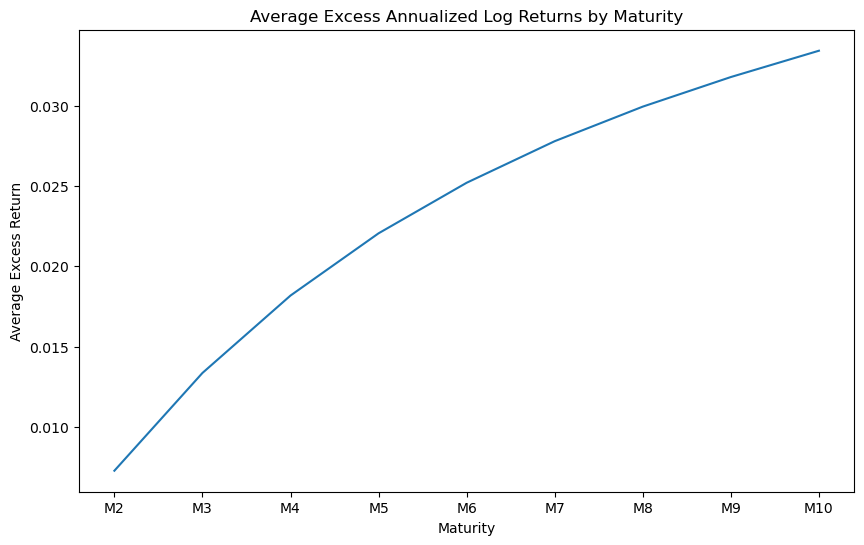

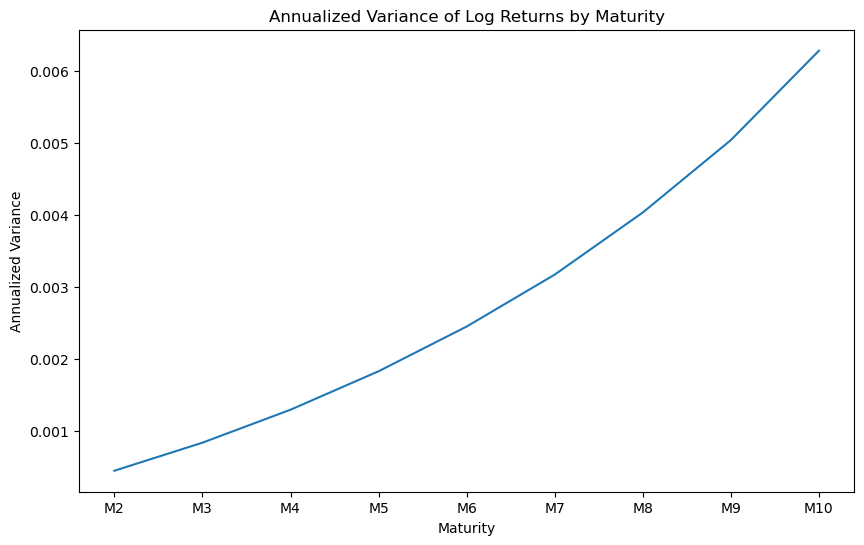

In [10]:
log_prices = y.copy()
for i in range(1, len(log_prices.columns)):
    log_prices.iloc[:,i] = y.iloc[:,i] * -i 

monthly_log_returns = log_prices.copy()
for t in range(0, len(log_prices)-1):
    for n in range(2, N+1):
        monthly_log_returns.iloc[t+1,n] = (
              11 * log_prices.iloc[t+1,n]/12
            + log_prices.iloc[t+1,n-1]/12
            - log_prices.iloc[t,n]
        )
        
# We drop the first period as it has no returns & the first maturity as it's risk-free
monthly_log_returns = monthly_log_returns.drop(0).drop(columns=['M1'])
monthly_excess_returns = monthly_log_returns.copy()
monthly_excess_returns.iloc[:, 1:] = monthly_excess_returns.iloc[:, 1:].apply(
    lambda maturity_returns: maturity_returns - y.iloc[:-1, 1].values/12, # only take out 1-month of risk-free rate
    axis=0)

annualized_excess_returns = monthly_excess_returns.iloc[:, 1:].mean(axis=0)*12
annualized_variance = monthly_log_returns.iloc[:, 1:].var(axis=0)*12

annualized_excess_returns.plot( figsize=(10, 6))
plt.title('Average Excess Annualized Log Returns by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Average Excess Return')
plt.show()

annualized_variance.plot( figsize=(10, 6))
plt.title('Annualized Variance of Log Returns by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Annualized Variance')
plt.show()

In [11]:
term_premia =  monthly_excess_returns.iloc[:, 1:].mean(axis=0) + .5* monthly_log_returns.iloc[:, 1:].var(axis=0)
term_premia

M2     0.000625
M3     0.001148
M4     0.001569
M5     0.001914
M6     0.002203
M7     0.002448
M8     0.002664
M9     0.002859
M10    0.003047
dtype: float64

In [12]:
B_opt_prices = B_opt[:-1] * np.arange(1, B_opt.shape[0])[:, np.newaxis] # undo 1/N scaling to get back to prices from yields
mu = np.linalg.inv(B_opt_prices.T @ B_opt_prices)@ B_opt_prices.T @ term_premia
lambda_0 = np.linalg.inv(sigma_opt)@mu
lambda_pc = np.linalg.inv(sigma_pc) @ mu_pc
sharpe_pc = np.sqrt(sigma_pc) @ lambda_pc
print("mu_reg:", mu)
print("lambda_0:", lambda_0) 
print("lambda_pc:", lambda_pc)
print("sharpe_pc:", sharpe_pc)

mu_reg: [-0.0003 -0.0004  0.0001]
lambda_0: [-69.001  -60.5376 -49.5291]
lambda_pc: [ 14.5941  95.5887 475.4548]
sharpe_pc: [0.1105 0.2571 0.8189]
